## Ratajczyk
# Lab 3

In [36]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Iterable, Callable
from utils import load_sequence, visualize, calculate_metrics, visualize_bounding_box

In [37]:
PEDESTRIAN_PATH: str = r"C:\Users\igor\Desktop\Studia\I\Semestr6\ZAW\Lab2\pedestrian"
OFFICE_PATH: str = r"C:\Users\igor\Desktop\Studia\I\Semestr6\ZAW\Lab2\office"
HIGHWAY_PATH: str = r"C:\Users\igor\Desktop\Studia\I\Semestr6\ZAW\Lab2\highway\highway"

Buffor

In [38]:
def buffor_method(
        image_stream_grayscale: List[np.ndarray],
        buffor_size: int,
        image_width: int,
        image_height: int,
        process_function: Callable[[np.ndarray, int], np.ndarray] = np.mean
) -> Iterable[np.ndarray]:
    buffor_idx: int = 0
    buffor: np.ndarray = np.zeros((image_height, image_width, buffor_size), dtype=np.uint8)
    for image in image_stream_grayscale:
        buffor[:, :, buffor_idx] = image
        processed_image = process_function(buffor, axis=2).astype(np.uint8)
        yield cv2.absdiff(processed_image, buffor[:, :, buffor_idx])
        buffor_idx = (buffor_idx + 1) % buffor_size

$\Sigma\Delta$

In [40]:
def sigma_delta(
        image_stream_grayscale: List[np.ndarray],
        alpha: float = 0.01,
        mimic_mean: bool = True
) -> Iterable[np.ndarray]:
    background: np.ndarray = image_stream_grayscale[0].copy().astype(np.float64)
    if mimic_mean:
        for image in image_stream_grayscale:
            background = (1 - alpha) * background + alpha * image.astype(np.float64)
            yield cv2.absdiff(image, background.astype(np.uint8))
    else:
        for image in image_stream_grayscale:
            background = background - (background > image).astype(np.uint8) + (background < image).astype(np.uint8)
            yield cv2.absdiff(image, background.astype(np.uint8))

Policy

In [41]:
def sigma_delta_conservative(
        image_stream_grayscale: List[np.ndarray],
        alpha: float = 0.01,
) -> Iterable[np.ndarray]:
    background: np.ndarray = image_stream_grayscale[0].copy().astype(np.float64)
    is_background: np.ndarray = np.ones_like(background, dtype=np.float64)
    for image in image_stream_grayscale:
        background = cv2.multiply((1-alpha) * background + alpha * image.astype(np.float64), is_background) + cv2.multiply(background, 1-is_background)
        diff = cv2.absdiff(image, background.astype(np.uint8))
        is_background = (diff < 10).astype(np.float64)
        yield diff

MoG

In [42]:
def mixture_of_gaussians(
        image_stream_grayscale: List[np.ndarray],
        init_mask: np.ndarray,
        history: int = 100,
        alpha: float = 0.01,
        detect_shadows: bool = False,
        threshold: float = 16
) -> Iterable[np.ndarray]:
    background_model = cv2.createBackgroundSubtractorMOG2(history=history, varThreshold=threshold, detectShadows=detect_shadows)
    mask: np.ndarray = init_mask.copy()
    for image in image_stream_grayscale:
        mask = background_model.apply(image, learningRate=alpha)
        yield mask

KNN

In [43]:
def knn(
        image_stream_grayscale: List[np.ndarray],
        init_mask: np.ndarray,
        history: int = 100,
        alpha: float = 0.01,
        detect_shadows: bool = False,
) -> Iterable[np.ndarray]:
    background_model = cv2.createBackgroundSubtractorKNN(history=history, detectShadows=detect_shadows)
    mask: np.ndarray = init_mask.copy()
    for image in image_stream_grayscale:
        mask = background_model.apply(image, learningRate=alpha)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
        yield mask

In [44]:
def sigma_delta_conservative_enhanced(
        image_stream_grayscale: List[np.ndarray],
        alpha: float = 0.1,
) -> Iterable[np.ndarray]:
    background: np.ndarray = image_stream_grayscale[0].copy().astype(np.float64)
    is_background: np.ndarray = np.zeros_like(background, dtype=np.float64)
    temperature: float = 1.
    for image in image_stream_grayscale:
        background = cv2.multiply((1-alpha) * background + alpha * image.astype(np.float64), is_background*(1-temperature)) + cv2.multiply(background, 1-is_background*(1-temperature))
        diff = cv2.absdiff(image, background.astype(np.uint8))
        is_background = is_background*(temperature) + (1-temperature)*(diff < 10).astype(np.float64)
        temperature -= 0.2
        if temperature < 0.1:
            temperature = 0
        yield diff

In [45]:
def VIBE(
        image_stream_grayscale: List[np.ndarray], 
        samples_per_pixel: int = 20,
        radius: int = 20,
        min_match_count: int = 2,
        random_subsample: int = 16,
) -> Iterable[np.ndarray]:
    samples = np.zeros((image_stream_grayscale[0].shape[0], image_stream_grayscale[0].shape[1], samples_per_pixel), dtype=np.uint8)
    for image in image_stream_grayscale:
        background = np.zeros_like(image, dtype=np.uint8)
        images = np.stack([image for _ in range(samples_per_pixel)], axis=2)
        dist = np.abs(samples-images)
        count = np.sum(dist < radius, axis=2)
        background = np.where(count >= min_match_count, 0, 255)     
        samples[:, :, np.random.randint(0, samples_per_pixel)] = image
        if np.random.random()* random_subsample < 1: samples[:,:, np.random.randint(0, samples_per_pixel)] = np.roll(image.copy(), np.random.randint(-1, 2), axis=np.random.randint(0, 2))

        yield background


In [34]:
sg = lambda x: 1 if x else -1

def sgn(x: np.ndarray) -> np.ndarray:
    t = x.copy()
    t[x < 0] = -1
    t[x >= 0] = 1
    return t



def PBAS(
        image_stream_grayscale: List[np.ndarray], 
        samples_per_pixel: int = 35,
        radius: int = 5,
        min_match_count: int = 2,
        r_inc_drc: float = 0.05,
        r_low : int = 18,
        r_scale = 5,
        T_dec = 0.05,
        T_inc = 1.05,
        T_lower = 2,
        T_upper = 200,
) -> Iterable[np.ndarray]:
    samples = np.zeros((image_stream_grayscale[0].shape[0], image_stream_grayscale[0].shape[1], samples_per_pixel), dtype=np.uint8)
    for image in image_stream_grayscale:
        background_model = np.zeros_like(image, dtype=np.uint8)
        samples = np.zeros((image.shape[0], image.shape[1], samples_per_pixel), dtype=np.uint8)
        radius = np.ones_like(image, dtype=np.uint8) * radius
        acc = np.zeros_like(image, dtype=np.uint8)
        D = np.zeros((image.shape[0], image.shape[1], samples_per_pixel) , dtype=np.uint8)
        R = np.ones_like(image, dtype=np.uint8) * r_low
        T = np.ones_like(image, dtype=np.uint8) * T_lower
        background = np.zeros_like(image, dtype=np.uint8)

        images = np.stack([image for _ in range(samples_per_pixel)], axis=2)
        dist = np.abs(samples-images)
        count = np.sum(dist < np.stack([R for _ in range(samples_per_pixel)], axis=2), axis=2)
        background = np.where(count >= min_match_count, 0, 255)

        yield background     


        mask = np.random.uniform(0, 1, size=image.shape) > T

        r = np.random.randint(0, samples_per_pixel)
        rolled = r = np.random.randint(0, samples_per_pixel)
        axis = np.random.randint(0, 2)
        dist = np.random.randint(-1, 2)

        samples[:, :, r] = image*mask + samples[:, :, r]*(1-mask)
        samples[:, :, rolled] = np.roll(image.copy(), dist, axis=axis)*mask + samples[:, :, rolled]*(1-mask)

        r = np.random.randint(0, samples_per_pixel)
        D[:, :, r] = np.min([np.sum(np.abs(image-samples[:,:, i]) for i in range(samples_per_pixel))])*mask + D[:, :, r]*(1-mask)
        acc = np.mean(D, axis=2)
        R = R*(1+sgn(R - r_scale*acc)*r_inc_drc)* mask + R*(1-mask)

        D[:,:, rolled] = np.min([np.sum(np.abs(image-samples[:,:, i]) for i in range(samples_per_pixel))])*mask + D[:,:, rolled]*(1-mask)
        R = R*(1+sgn(R - r_scale*np.mean(D, axis=2))*r_inc_drc)* mask + R*(1-mask)


        T = np.minimum(np.maximum(T_lower, T + sgn(background_model)* T_inc/ (0.01+acc)), T_upper)

                


Comparison

In [4]:
pedestrian_sequence: List[np.ndarray] = load_sequence(PEDESTRIAN_PATH)
pedestrian_ground_truth: List[np.ndarray] = load_sequence(PEDESTRIAN_PATH, False)
pedestrian_colour : List[np.ndarray] = load_sequence(PEDESTRIAN_PATH, True, False)

office_sequence: List[np.ndarray] = load_sequence(OFFICE_PATH)
office_ground_truth: List[np.ndarray] = load_sequence(OFFICE_PATH, False)
office_colour : List[np.ndarray] = load_sequence(OFFICE_PATH, True, False)

highway_sequence: List[np.ndarray] = load_sequence(HIGHWAY_PATH)
highway_ground_truth: List[np.ndarray] = load_sequence(HIGHWAY_PATH, False)
highway_colour : List[np.ndarray] = load_sequence(HIGHWAY_PATH, True, False)

F1 score comparison

In [46]:
def mask(image) -> np.ndarray:
    return cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)[1].astype(np.uint8)*(230>np.max(image)>100).astype(np.uint8)*255

kernel_dilate: np.ndarray = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,23))
kernel_erode: np.ndarray = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,29))
process: Callable[[np.ndarray], np.ndarray] = lambda image: cv2.morphologyEx(cv2.morphologyEx(mask(image), cv2.MORPH_DILATE, kernel_dilate), cv2.MORPH_ERODE, kernel_erode)*255

In [47]:
visualize_bounding_box(pedestrian_colour, [process(image) for image in buffor_method(pedestrian_sequence, 100, 360, 240)])

In [30]:
print(f"Buffor mean method for pedestrian: {calculate_metrics([process(image) for image in buffor_method(pedestrian_sequence, 100, 360, 240)], pedestrian_ground_truth)[0]}")
print(f"Buffor mean method for office: {calculate_metrics([process(image) for image in buffor_method(office_sequence, 100, 360, 240)], office_ground_truth)[0]}")
print(f"Buffor mean method for highway: {calculate_metrics([process(image) for image in buffor_method(highway_sequence, 100, 320, 240)], highway_ground_truth)[0]}")

Buffor mean method for pedestrian: 0.21378798629261359
Buffor mean method for office: 0.410860339806031
Buffor mean method for highway: 0.5683832618808403


In [31]:
print(f"Buffor mean method for pedestrian: {calculate_metrics([process(image) for image in buffor_method(pedestrian_sequence, 100, 360, 240, np.median)], pedestrian_ground_truth)[0]}")
print(f"Buffor mean method for office: {calculate_metrics([process(image) for image in buffor_method(office_sequence, 100, 360, 240, np.median)], office_ground_truth)[0]}")
print(f"Buffor mean method for highway: {calculate_metrics([process(image) for image in buffor_method(highway_sequence, 100, 320, 240, np.median)], highway_ground_truth)[0]}")

Buffor mean method for pedestrian: 0.7354100659486974
Buffor mean method for office: 0.2996008336983528
Buffor mean method for highway: 0.8150766578490902


In [16]:
visualize_bounding_box(pedestrian_colour, [process(image) for image in buffor_method(pedestrian_sequence, 100, 360, 240, np.median)])

$\alpha$ parameter fine-tuning

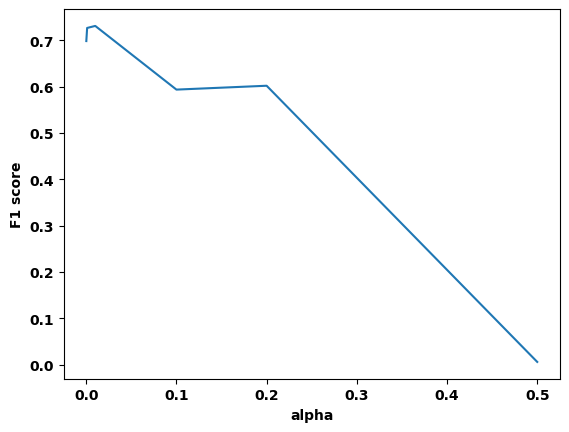

In [26]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, .2, .5]
values = [calculate_metrics([process(image) for image in sigma_delta(pedestrian_sequence, alpha=alpha)], pedestrian_ground_truth)[0] for alpha in alphas]

plt.plot(alphas, values)
plt.xlabel("alpha")
plt.ylabel("F1 score")
plt.show()

In [18]:
print(f"Sigma-delta mean-mimic method for pedestrian: {calculate_metrics([process(image) for image in sigma_delta(pedestrian_sequence)], pedestrian_ground_truth)[0]}")
print(f"Sigma-delta mean-mimic method for office: {calculate_metrics([process(image) for image in sigma_delta(office_sequence)], office_ground_truth)[0]}")
print(f"Sigma-delta mean-mimic method for highway: {calculate_metrics([process(image) for image in sigma_delta(highway_sequence)], highway_ground_truth)[0]}")

Sigma-delta mean-mimic method for pedestrian: 0.7309719807488301
Sigma-delta mean-mimic method for office: 0.5436423038102987
Sigma-delta mean-mimic method for highway: 0.8226961938358833


In [19]:
visualize([process(image) for image in sigma_delta(pedestrian_sequence)])

In [20]:
print(f"Sigma-delta median-mimic method for pedestrian: {calculate_metrics([process(image) for image in sigma_delta(pedestrian_sequence, mimic_mean=False)], pedestrian_ground_truth)[0]}")
print(f"Sigma-delta median-mimic method for office: {calculate_metrics([process(image) for image in sigma_delta(office_sequence, mimic_mean=False)], office_ground_truth)[0]}")
print(f"Sigma-delta median-mimic method for highway: {calculate_metrics([process(image) for image in sigma_delta(highway_sequence, mimic_mean=False)], highway_ground_truth)[0]}")

Sigma-delta median-mimic method for pedestrian: 0.7698851645159699
Sigma-delta median-mimic method for office: 0.43684414758916595
Sigma-delta median-mimic method for highway: 0.8287966818264206


In [55]:
print(f"Conservative approach for sigma-delta mean-mimic method for pedestrian: {calculate_metrics([process(image) for image in sigma_delta_conservative(pedestrian_sequence)], pedestrian_ground_truth)[0]}")
print(f"Conservative approach for sigma-delta mean-mimic method for office: {calculate_metrics([process(image) for image in sigma_delta_conservative(office_sequence)], office_ground_truth)[0]}")
print(f"Conservative approach for sigma-delta mean-mimic method for highway: {calculate_metrics([process(image) for image in sigma_delta_conservative(highway_sequence)], highway_ground_truth)[0]}")

Conservative approach for sigma-delta mean-mimic method for pedestrian: 0.7751106824606134
Conservative approach for sigma-delta mean-mimic method for office: 0.5414354622808929
Conservative approach for sigma-delta mean-mimic method for highway: 0.6554275838812151


In [24]:
print(f"MoG method for pedestrian: {calculate_metrics([image for image in mixture_of_gaussians(pedestrian_sequence, pedestrian_sequence[0], detect_shadows=False)], pedestrian_ground_truth)[0]}")
print(f"MoG method for office: {calculate_metrics([image for image in mixture_of_gaussians(office_sequence, office_sequence[0], detect_shadows=False)], office_ground_truth)[0]}")
print(f"MoG method for highway: {calculate_metrics([image for image in mixture_of_gaussians(highway_sequence, highway_sequence[0], detect_shadows=False)], highway_ground_truth)[0]}")


MoG method for pedestrian: 0.565975459124566
MoG method for office: 0.1474553172577852
MoG method for highway: 0.6417823118368964


In [25]:
print(f"KNN method for pedestrian: {calculate_metrics([image for image in knn(pedestrian_sequence, pedestrian_sequence[0], detect_shadows=False)], pedestrian_ground_truth)[0]}")
print(f"KNN method for office: {calculate_metrics([image for image in knn(office_sequence, office_sequence[0], detect_shadows=False)], office_ground_truth)[0]}")
print(f"KNN method for highway: {calculate_metrics([image for image in knn(highway_sequence, highway_sequence[0], detect_shadows=False)], highway_ground_truth)[0]}")

KNN method for pedestrian: 0.38491767829399126
KNN method for office: 0.2264554458877772
KNN method for highway: 0.6553705603488084


In [19]:
print(f"VIBE method for pedestrian: {calculate_metrics([image for image in VIBE(pedestrian_sequence)], pedestrian_ground_truth)[0]}")

VIBE method for pedestrian: 0.21989116288416022


In [35]:
print(f"PBAS method for pedestrian: {calculate_metrics([image for image in PBAS(pedestrian_sequence)], pedestrian_ground_truth)[0]}")

C:\Users\igor\AppData\Local\Temp\ipykernel_7828\505360864.py:54: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  D[:, :, r] = np.min([np.sum(np.abs(image-samples[:,:, i]) for i in range(samples_per_pixel))])*mask + D[:, :, r]*(1-mask)
C:\Users\igor\AppData\Local\Temp\ipykernel_7828\505360864.py:58: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  D[:,:, rolled] = np.min([np.sum(np.abs(image-samples[:,:, i]) for i in range(samples_per_pixel))])*mask + D[:,:, rolled]*(1-mask)


PBAS method for pedestrian: 0.03156401378391493


In [92]:
print(f"Conservative approach for sigma-delta mean-mimic method for pedestrian: {calculate_metrics([process(image) for image in sigma_delta_conservative(office_sequence[250:])], office_sequence[250:])[0]}")
print(f"Conservative approach for sigma-delta mean-mimic method for pedestrian but enhanced: {calculate_metrics([process(image) for image in sigma_delta_conservative_enhanced(office_sequence[250:])], office_sequence[250:])[0]}")

Conservative approach for sigma-delta mean-mimic method for pedestrian: 0.046230491346539795
Conservative approach for sigma-delta mean-mimic method for pedestrian but enhanced: 0.19534214662285046
